# <div align="center"><b> TP2 - VPC3 - MIA </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-vpc3/mia-vpc3/Practicos/Practico%202/practico2.ipynb">Ruta archivo</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻


Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

> 📝 <em><font color='Gray'>Nota:</font></em> Para agregar `pytorch` utilizando Poetry, se utiliza el siguiente comando:
> ```bash
> # Más info: https://github.com/python-poetry/poetry/issues/6409
> potery source add --priority explicit pytorch_gpu https://download.pytorch.org/whl/cu128 # Seleccionar la wheel adecuada para tu GPU
> poetry add --source pytorch_gpu torch torchvision 
> ```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer, EarlyStopping

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
print(f"Dispositivo actual: {DEVICE}")
# torch.set_float32_matmul_precision('highest') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'más alta'.
torch.set_float32_matmul_precision('high') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'alta'.
# torch.set_float32_matmul_precision('medium') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'media'.
# torch.backends.cudnn.benchmark = True # Optimización: Para redes CNN (pero como se usa una capa convolucional, se establece en True).

Dispositivo actual: cuda


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Practico 2 - Visión por computadora 3 - FIUBA                                                                                                              |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Construir un Vision Transformer                                                                                           |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

## Resolución

### Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

#### Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
#### ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token: 

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen. 

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


### Tareas

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation** 

In [16]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Dispositivo: ", device)
print("Torch version: ", torch.__version__)


# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    """
    Esta clase se encarga de la configuración y preprocesamiento de imágenes.

    Atributos:
        device (str): El dispositivo donde se realizarán los cálculos (cpu, cuda, mps).
        img_path (str): La ruta de la imagen a procesar.
        img_size (int): El tamaño al que se redimensionará la imagen.
        patch_size (int): El tamaño de los parches que se extraerán de la imagen.

    Métodos:
        load_image(): Carga y preprocesa la imagen desde la ruta especificada.
        extract_patches(image: Tensor) -> Tensor: Extrae parches de la imagen procesada.
    """

    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        """
        Carga y preprocesa la imagen desde la ruta especificada.

        Returns:
            Tensor: Imagen preprocesada como un tensor de PyTorch, con dimensiones
            (1, canales, alto, ancho) y transferida al dispositivo especificado.
        """
        return (
            TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size)))
            .unsqueeze(0)  # Añadir dimensión de batch
            .to(self.device)
        )

    def extract_patches(self, image: Tensor) -> Tensor:
        """
        Extrae parches 2D de la imagen tensorial de entrada.

        Args:
            image (Tensor): Tensor de la imagen de entrada con forma (B, C, H, W).

        Returns:
            Tensor: Parches extraídos con forma (B, num_patches, patch_size, patch_size).

        Resumen:
        Este método utiliza la función `unfold` para extraer ventanas deslizantes (parches) de la imagen.
        El primer `unfold` se aplica a la altura (dimensión 1) y el segundo al ancho (dimensión 2).
        El tamaño de la ventana deslizante es `patch_size` con un paso igual a `patch_size`, asegurando que no haya superposición.
        Después de aplicar `unfold`, el método `contiguous` asegura que los datos estén almacenados en memoria contigua.
        Finalmente, el método `view` reorganiza los parches con forma (B, num_patches, patch_size, patch_size),
        donde `-1` infiere automáticamente el número de parches.
        """
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)    # Cada filtro (kernel) tiene el tamaño del parche y como el stride tambien
                                                                                                    # es del tamaño del parche, divide a la imagen en una grilla de parches no
                                                                                                    # superpuestos. El número de filtros (kernels) es igual a embed_dim (o sea, 
                                                                                                    # el tamaño del mapa de activación)  A parte de dividir, también se 
                                                                                                    # proyecta cada parche a un espacio de embedding.

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding


# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device, img_path, img_size, patch_size)

with Image.open(img_path) as img:
    print(f"Dimensiones de la imagen original: {img.size}")
    print(f"Canales: {img.mode}")


print(f"Imagen de prueba cargada: {config.img_path}")
print(f"Tamaño de la imagen: {config.img_size}x{config.img_size}")
print(f"Tamaño del parche: {config.patch_size}x{config.patch_size}")
print(f"Dimensiones de la imagen de prueba: {config.test_img.shape}")

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(
        f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}."
    )

Dispositivo:  cuda
Torch version:  2.7.0+cu128
Dimensiones de la imagen original: (1254, 836)
Canales: RGB
Imagen de prueba cargada: raccoon.jpg
Tamaño de la imagen: 900x900
Tamaño del parche: 64x64
Dimensiones de la imagen de prueba: torch.Size([1, 3, 900, 900])


### Transformer Encoder

#### nn.TransformerEncoderLayer

<small><em>https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html</em></small>

La capa `nn.TransformerEncoderLayer` es un bloque básico de la arquitectura Transformer. Esta capa aplica el mecanismo de atención y una red neuronal feedforward a la entrada, permitiendo que el modelo aprenda representaciones complejas de los datos. Es la capa estándar basada en el paper "Attention is All You Need" de Vaswani et al. (2017).

Parámetros:
- **d_model** (int): Número de "features" esperadas en la entrada (requerido).
- **nhead** (int): Número de cabezas en los modelos de atención múltiple (requerido).
- **dim_feedforward** (int): Dimensión de la red feedforward (por defecto=2048).
- **dropout** (float): Valor de dropout (por defecto=0.1).
- **activation** (str o Callable): Función de activación de la capa intermedia, puede ser una cadena ("relu" o "gelu") o una función callable. Por defecto: relu.
- **layer_norm_eps** (float): Valor de epsilon en los componentes de normalización de capas (por defecto=$1e^{-5}$).
- **batch_first** (bool): Si es `True`, los tensores de entrada y salida se proporcionan como (batch, seq, feature). Por defecto: `False` (seq, batch, feature).
- **norm_first** (bool): Si es `True`, la normalización de capas se realiza antes de las operaciones de atención y feedforward. De lo contrario, se realiza después. Por defecto: `False` (después).
- **bias** (bool): Si se establece en False, las capas Linear y LayerNorm no aprenderán un sesgo aditivo. Por defecto: `True`.

> 📝 <em><font color='Gray'>Nota:</font></em> Se puede utilizar "FlashAttention" pero hay que hacer cumplir algunas condiciones.

#### nn.TransformerEncoder
<small><em>https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html</em></small>

Es un stack de N capas de `nn.TransformerEncoderLayer`. Esta clase permite apilar múltiples capas de codificación Transformer, lo que facilita la construcción de modelos más profundos y complejos.

Parámetros:
- **encoder_layer** (nn.TransformerEncoderLayer): Una instancia de la capa `nn.TransformerEncoderLayer`.
- **num_layers** (int): Número de capas en el stack.
- **norm** (nn.Module): Componente de normalización (opcional).
- **enable_nested_tensor** (bool): Si es `True`, permite el uso de tensores anidados. Por defecto: `False`.

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(
        self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first: bool = True
    ):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            # bias=False,
            batch_first=batch_first,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

### Vision Transformer
Model
> 
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [18]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int,
        patch_size: int,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        num_layers: int,
        dropout: float = 0.1,
        in_channels: int = 3,
        num_classes: int = 10,
        batch_first: bool = True,
    ):
        super(VisionTransformer, self).__init__()
        patch_num = (img_size // patch_size) ** 2

        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        # self.positional_encoding = PositionalEncodingLearned(patch_num, embed_dim)
        self.positional_encoding_cls = PositionalEncodingLearned(patch_num + 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Token CLS
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout, batch_first)
        self.fc = nn.Linear(embed_dim, num_classes)

    # Forward pass utilizando la media de los parches
    # def forward(self, x):
    #     x = self.patch_embedding(x) # (B, C, H, W) -> (B, num_patches, embed_dim)
    #     x = self.positional_encoding(x) # (B, num_patches, embed_dim) -> (B, num_patches, embed_dim)
    #     x = self.transformer_encoder(x) # (B, num_patches, embed_dim) -> (B, num_patches, embed_dim)
    #     x = x.mean(dim=1) # (B, num_patches, embed_dim) -> (B, embed_dim) # Promediar los parches
    #     x = self.fc(x) # (B, embed_dim) -> (B, num_classes)
    #     return x # (B, num_classes)
    
    # Forward pass utilizando token CLS
    def forward(self, x):
        x = self.patch_embedding(x) # (B, C, H, W) -> (B, num_patches, embed_dim)

        batch_size = x.size(0)
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (B, 1, embed_dim) # Expande el token CLS para que coincida con el tamaño del batch
        x = torch.cat((cls_token, x), dim=1) # (B, num_patches, embed_dim) -> (B, num_patches + 1, embed_dim)

        x = self.positional_encoding_cls(x) # (B, num_patches + 1, embed_dim) -> (B, num_patches + 1, embed_dim)
        x = self.transformer_encoder(x) # (B, num_patches + 1, embed_dim) -> (B, num_patches + 1, embed_dim)
        x = x[:, 0] # Obtener el token CLS (B, num_patches + 1, embed_dim) -> (B, embed_dim)
        x = self.fc(x) # (B, embed_dim) -> (B, num_classes)
        return x # (B, num_classes)

### CIFAR10

Para este conjunto (CIFAR10), se definen las siguientes transformaciones:

In [19]:
# Define transformations for the input data
transform_orignial = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

transform_1 = transforms.Compose(
    [
        # Transformaciones geométricas
        transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal de la imagen con una probabilidad de 0.5
        transforms.RandomVerticalFlip(p=0.5),  # Flip vertical de la imagen con una probabilidad de 0.5
        # Transofrmaciones de color
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),  # Ajuste aleatorio del brillo, contraste, saturación y matiz de la imagen
        transforms.RandomGrayscale(p=0.1),  # Conversión aleatoria a escala de grises con una probabilidad de 0.1
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

transform_2 = transforms.Compose(
    [
        # Transformaciones geométricas
        transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal de la imagen con una probabilidad de 0.5
        transforms.RandomVerticalFlip(p=0.5),  # Flip vertical de la imagen con una probabilidad de 0.5
        transforms.RandomRotation(degrees=15),  # Rotación aleatoria de la imagen en un rango de -15 a 15 grados
        transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=None
        ),  # Transformación afín aleatoria que incluye traslación (hasta 10%), escalado (90% a 110%)
        transforms.RandomResizedCrop(
            size=32, scale=(0.8, 1.0), ratio=(0.75, 1.33)
        ),  # Recorte aleatorio redimensionado de la imagen a un tamaño de 32x32, con una escala entre 80% y 100% y una relación de aspecto entre 0.75 y 1.33
        # Transofrmaciones de color
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),  # Ajuste aleatorio del brillo, contraste, saturación y matiz de la imagen
        transforms.RandomGrayscale(p=0.1),  # Conversión aleatoria a escala de grises con una probabilidad de 0.1
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

> 📝 <em><font color='Gray'>Nota:</font></em> Otra transformación interesante:
> ```python
> # Otras transformaciones
> transforms.RandomErasing(
>     p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0
> ),  # Borrado aleatorio de un cuadrado la imagen con una probabilidad de 0.5 (creo que lo rellena con 0)
> ```
> Sin embargo, esta transformación no soporta imagenes PIL. En la documentación se menciona que se puede aplicar de la siguiente manera:
> ```python
> transform = transforms.Compose([
>   transforms.RandomHorizontalFlip(),
>   transforms.PILToTensor(),
>   transforms.ConvertImageDtype(torch.float),
>   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
>   transforms.RandomErasing(),
> ])
> ```

Cabe destacar que las transformaciones implican un mayor aumento de cómputo, ya que se aplican a cada imagen de entrada. Esto puede aumentar el tiempo de entrenamiento, pero también puede mejorar la generalización del modelo. Hay dos tipos de transformaciones, unas básicas y otras más avanzadas.

In [20]:
transform_train = transform_1 # Basicas
# transform_train = transform_2 # Avanzadas

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

# Load your dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

In [21]:
# Chequear el dataset
images, labels = next(iter(train_loader))
print(f"Cantidad de imágenes: {len(train_loader.dataset)}")
print(f"Dimensiones de las imágenes: {images.shape}")
print(f"Dimensiones de las etiquetas: {labels.shape}")
print(f"Primeras 10 etiquetas: {labels[:10]}")

Cantidad de imágenes: 50000
Dimensiones de las imágenes: torch.Size([512, 3, 32, 32])
Dimensiones de las etiquetas: torch.Size([512])
Primeras 10 etiquetas: tensor([1, 9, 8, 1, 2, 2, 4, 0, 8, 0])


In [22]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


### Modelo

Para el ajuste de los hiperparámetros, se utilizarán como referencia los parámetros del modelo ViT-Base y sus variantes (Large y Huge).

| Model       | Layers | Hidden Size (D) | MLP Size | Heads | Params |
|-------------|--------|------------------|----------|-------|--------|
| ViT-Base    | 12     | 768              | 3072     | 12    | 86M    |
| ViT-Large   | 24     | 1024             | 4096     | 16    | 307M   |
| ViT-Huge    | 32     | 1280             | 5120     | 16    | 632M   |

In [ ]:
num_epochs = 100 # Activé el early stopping

model_xs = VisionTransformer(
    img_size=32,
    patch_size=4, # -> 64 patches
    embed_dim=8,
    num_heads=4,
    ff_dim=32,
    num_layers=12,
    dropout=0.1,
    in_channels=3,
    num_classes=10
)

model_s = VisionTransformer(
    img_size=32,
    patch_size=4, # -> 64 patches
    embed_dim=16,
    num_heads=8,
    ff_dim=64,
    num_layers=12,
    dropout=0.1,
    in_channels=3,
    num_classes=10
)

model_b = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=768,
    num_heads=12,
    ff_dim=3072,
    num_layers=12,
    dropout=0.1,
    in_channels=3,
    num_classes=10
)

model_l = VisionTransformer(
    img_size=32,
    patch_size=16,
    embed_dim=1024,
    num_heads=16,
    ff_dim=4096,
    num_layers=24,
    dropout=0.1,
    in_channels=3,
    num_classes=10
)

model_h = VisionTransformer(
    img_size=32,
    patch_size=16,
    embed_dim=1280,
    num_heads=16,
    ff_dim=5120,
    num_layers=32,
    dropout=0.1,
    in_channels=3,
    num_classes=10
)

# model = model_xs.to(device)
# model = model_s.to(device)
model = model_b.to(device)
# model = model_l.to(device)
# model = model_h.to(device)

print("Resumen del modelo:")
print(model)
print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4) 
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=3
# )
# warmup_epochs = 5
# def warmup_lr_scheduler(epoch):
#     return min((epoch + 1) / warmup_epochs, 1.0)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_lr_scheduler)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

model = model.to(device)

try:
    # Utilizar triton: https://github.com/woct0rdho/triton-windows/releases
    # model = torch.compile(model)
    model = torch.compile(model, "max-autotune") # Optimización: Use CUDA Graphs
except Exception as e:
    print("Se produjo error durante la compilación:", e)

In [24]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000


torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 85.15 millones


In [13]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

best_val_loss = float("inf")
for epoch in range(num_epochs):
    trainer.train_model(use_amp=True)

    val_loss = trainer.eval_model()
    if early_stopping(trainer.model, val_loss):
        print(f"Early stopping at epoch {epoch}")
        break

    scheduler.step(val_loss)  # Ajustar la tasa de aprendizaje según el scheduler

loss 2.32698:  15%|█▌        | 15/98 [00:11<01:03,  1.30it/s]


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    return accuracy, precision, recall, f1


# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 20/20 [00:01<00:00, 14.06it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.58
Precision: 0.58
Recall: 0.58
F1 score: 0.57


In [ ]:
train_dataset.data[0].shape

(32, 32, 3)

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


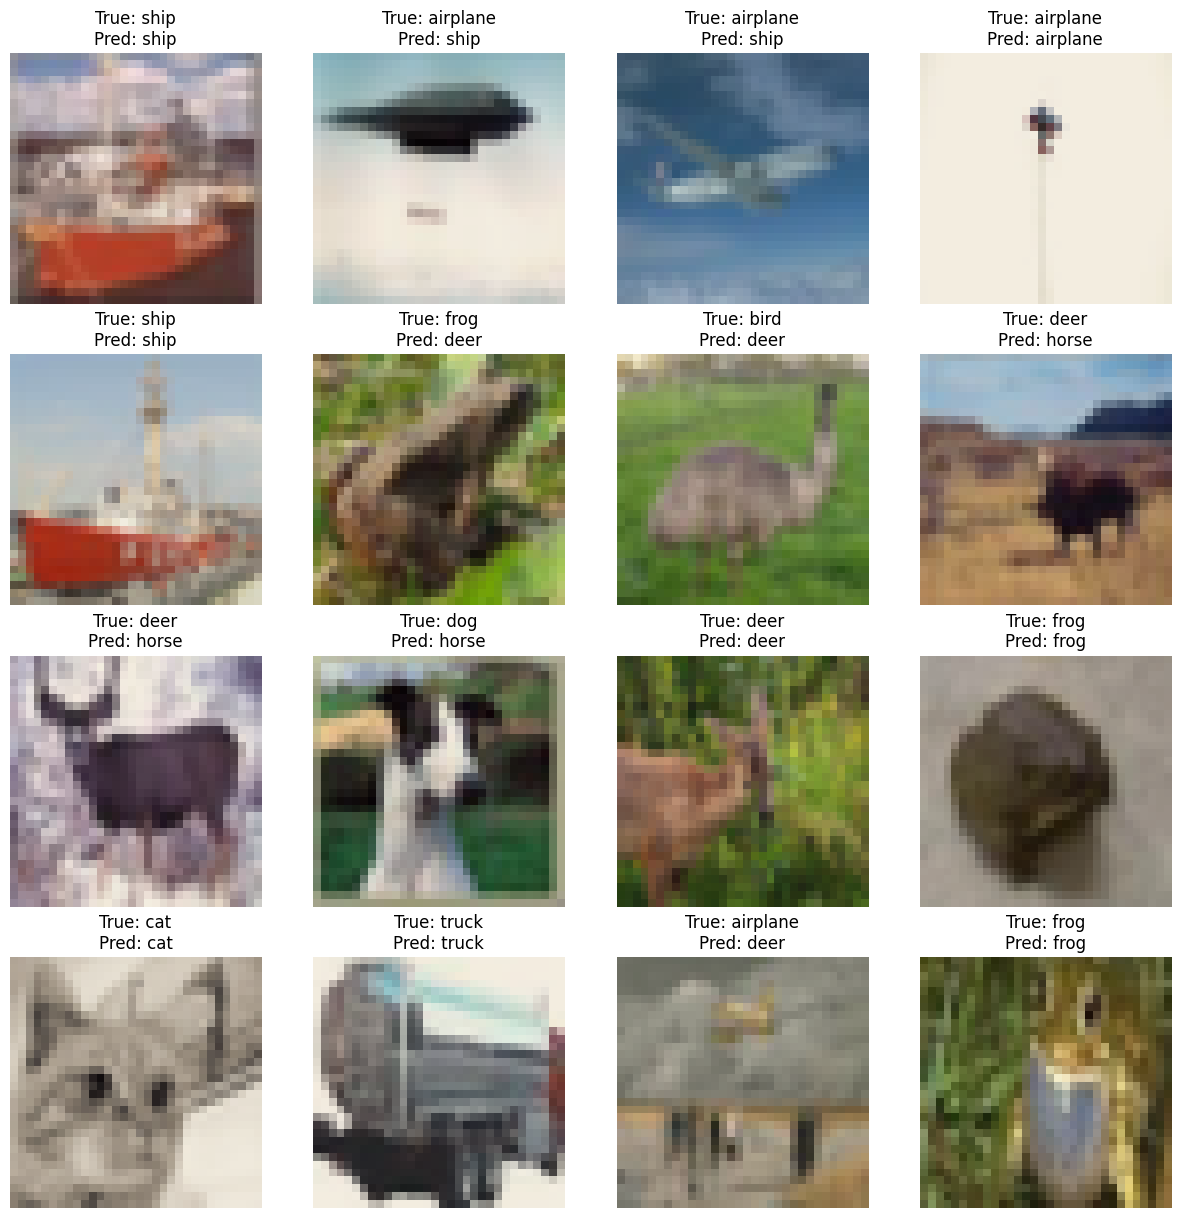

In [ ]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis("off")
                ax.set_title(f"True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}")
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


class_names = train_dataset.classes
print(f"Clases: {class_names}")
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

> ⭐ <em><strong>Conclusión:</strong></em> Después de realizar pruebas con diferentes configuraciones de modelos, se llegó a la conclusión que para este conjunto de datos, el modelo "custom" de tamaño *small* era el más adecuado y el que brindó mejores resultados:
>```python
>VisionTransformer(
>    img_size=32,
>    patch_size=4, # -> 64 patches
>    embed_dim=16,
>    num_heads=8,
>    ff_dim=64,
>    num_layers=12,
>    dropout=0.1,
>    in_channels=3,
>    num_classes=10,
>    batch_first=True,
>)
>```
>
> De las transformaciones, se utilizó el método más simple, dado que no hacía mucha diferencia utilizar las transformaciones más complejas:
> ```python
> transforms.Compose(
>     [
>         # Transformaciones geométricas
>         transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal de la imagen con una probabilidad de 0.5
>         transforms.RandomVerticalFlip(p=0.5),  # Flip vertical de la imagen con una probabilidad de 0.5
>         # Transofrmaciones de color
>         transforms.ColorJitter(
>             brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
>         ),  # Ajuste aleatorio del brillo, contraste, saturación y matiz de la imagen
>         transforms.RandomGrayscale(p=0.1),  # Conversión aleatoria a escala de grises con una probabilidad de 0.1
>         transforms.ToTensor(),
>         transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
>     ]
> )
> ```
>
> Es importante destacar que se debe realizar un mejor análisis de datos para determinar qué transformaciones son las más adecuadas para cada conjunto de datos. En este caso, se utilizó el método más simple, pero en otros casos puede ser necesario utilizar métodos más complejos.
> En la siguiente tabla se puede observar los resultados de las pruebas:
>
> | **Modelo**  | **Transformaciones** | **Accuracy** | **Precision** | **Recall** | **F1 Score** | **Tiempo** | **Tamaño parches** |
> |-------------|----------------------|--------------|---------------|------------|--------------|------------|--------------------|
> | *XS*        | Básicas              | 0.46         | 0.46          | 0.46       | 0.45         | 48 min     | 4                  |
> | *XS*        | Avanzadas            | 0.41         | 0.41          | 0.41       | 0.39         | 64 min     | 4                  |
> | *S*         | Básicas              | 0.58         | 0.58          | 0.58       | 0.57         | 55 min     | 4                  |
> | *S*         | Avanzadas            | 0.54         | 0.53          | 0.54       | 0.52         | 76 min     | 4                  |
> | *ViT-Base*  | Básicas              | 0.1          | 0.01          | 0.1        | 0.02         | 77 min     | 4                  |
> | *ViT-Base*  | Avanzadas            | 0.1          | 0.01          | 0.1        | 0.02         | 81 min     | 4                  |
> | *ViT-Large* | Básicas              | 0.1          | 0.01          | 0.1        | 0.02         | 8 min      | 16                 |
> | *ViT-Huge*  | Basicas              | 0.1          | 0.01          | 0.1        | 0.02         | 99 min     | 16                 |
>
> Como nota adicional, se probaron varias optimizaciones especificadas en el siguiente artículo: https://docs.pytorch.org/tutorials/recipes/recipes/tuning_guide.html, pero una de las conclusiones que se llegó es que uno de los parámetros más importantes para la performance del modelo es el tamaño del parche. Para el modelo ViT-Large, se probó con el mismo tamaño de parche que los anteriores, pero su tiempo de entrenamiento se extendía más de 24 horas, inclusive con las optimizaciones.
> Otro punto destacable es el tema del aprendizaje. Para los casos de los modelos del paper (ViT-Base, ViT-Large y ViT-Huge), la pérdida en entrenamiento se mantenía sobre 2.30, lo que indicaba que el modelo no estaba aprendiendo. Tampoco había sobreajuste porque la perdida en validación era similar. Y como dato adicional, en un conjunto con 10 clases, la perdida de un clasificador aleatorio para cada clase sería $log(10) \approx 2.30$, que era donde se estancaba los modelos. O sea, los modelos no aprendieron nada. En cambio, para el modelo custom, la perdida de entrenamiento y validación eran similares y se mantenían en 0.5, lo que indicaba que el modelo estaba aprendiendo. Opciones para probar en un futuro para tratar este problema en los modelos del paper:
> - Tasa de aprendizaje más alta: Probar con valores más altos de tasa de aprendizaje, como 0.01 o 0.1. Actualmente se está utilizando 0.001. Ojo, acá si se pone muy alta puede pasar de que salte de un lado al otro y no converja. Y muy baja es que directamente no le hace efecto.
> - Inicialización de los pesos: Probar otras inicializaciones como Xavier o He.